# Reliability testing in  FlexPlan

In [7]:
using Revise
import FlexPlan; const _FP = FlexPlan
import PowerModelsACDC; const _PMACDC = PowerModelsACDC
import PowerModels; const _PM = PowerModels
import InfrastructureModels; const _IM = InfrastructureModels

import JuMP
import Cbc

using JuliaDB
using Plots

┌ Info: Precompiling FlexPlan [196f2941-2d58-45ba-9f13-43a2532b2fa8]
└ @ Base loading.jl:1260
┌ Warning: Package FlexPlan does not have DataStructures in its dependencies:
│ - If you have FlexPlan checked out for development and have
│   added DataStructures as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with FlexPlan
└ Loading DataStructures into FlexPlan from project dependency, future warnings for FlexPlan are suppressed.


Solver configurations:

In [8]:
cbc = JuMP.with_optimizer(Cbc.Optimizer, tol=1e-4, print_level=0)

┌ Warning: `with_optimizer` is deprecated. Adapt the following example to update your code:
│ `with_optimizer(Ipopt.Optimizer, max_cpu_time=60.0)` becomes `optimizer_with_attributes(Ipopt.Optimizer, "max_cpu_time" => 60.0)`.
│   caller = ip:0x0
└ @ Core :-1


MathOptInterface.OptimizerWithAttributes(Cbc.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute,Any}[MathOptInterface.RawParameter("tol") => 0.0001, MathOptInterface.RawParameter("print_level") => 0])

Input parameters:

In [9]:
number_of_hours = 60 # Number of time points
file = "./test/data/case6_reliability.m";  #Input case, in matpower m-file format: Here 6bus case with candidate AC, DC lines and candidate storage

Define contingency scenarios for base case (no contingecies):

In [10]:
scenario = Dict{String, Any}("hours" => number_of_hours, "contingency" => Dict{String, Any}())
# Base scenario
scenario["contingency"]["0"] = Dict{String, Any}()
scenario["contingency"]["0"]["year"] = 2019
scenario["contingency"]["0"]["start"] = 1546300800000   # 01.01.2019:00:00 in epoch time
scenario["contingency"]["0"]["probability"] = 1.0
scenario["contingency"]["0"]["faults"] = Dict()
scenario["utypes"] = []#, "branchdc_ne"] # type of lines considered in contingencies
scenario["planning_horizon"] = 1 # in years, to scale generation cost  

1

# Define and modify input-data

Load system data from file:

In [11]:
data = _PM.parse_file(file); # Create PowerModels data dictionary (AC networks and storage)

[info | PowerModels]: extending matpower format with data: storage_extra 1x4
[info | PowerModels]: extending matpower format with data: convdc 4x35
[info | PowerModels]: extending matpower format with data: busdc 4x9
[info | PowerModels]: extending matpower format with data: convdc_ne 6x37
[info | PowerModels]: extending matpower format with data: ne_storage 1x25
[info | PowerModels]: extending matpower format with data: busdc_ne 4x9
[info | PowerModels]: extending matpower format with data: load_extra 5x19
[info | PowerModels]: extending matpower format with data: branchdc_ne 3x12
[info | PowerModels]: extending matpower format with data: ne_branch 2x15
[info | PowerModels]: extending matpower format with data: branchdc 2x10
[info | PowerModels]: extending matpower format with constant data: time_elapsed
[info | PowerModels]: extending matpower format by appending matrix "storage_extra" in to "storage"
[warn | PowerModels]: the voltage setpoint on generator 2 does not match the value 

Create data for the contingency model based on system data and contingency scenarios:

In [12]:

data, contingency_profile, loadprofile, genprofile = _FP.create_contingency_data_italy(data, scenario) # create load and generation profiles
_PMACDC.process_additional_data!(data) # Add DC grid data to the data dictionary
_FP.add_storage_data!(data) # Add addtional storage data model
_FP.add_flexible_demand_data!(data) # Add flexible data model
_FP.scale_cost_data!(data, scenario) # Scale cost data



┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `using DataFrames; CSV.read(input, DataFrame; kw...)
│   caller = read at CSV.jl:40 [inlined]
└ @ Core C:\Users\espenb\.julia\packages\CSV\MKemC\src\CSV.jl:40
┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `using DataFrames; CSV.read(input, DataFrame; kw...)
│   caller = read at CSV.jl:40 [inlined]
└ @ Core C:\Users\espenb\.julia\packages\CSV\MKemC\src\CSV.jl:40
┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `using DataFrames; CSV.read(input, DataFrame; kw...)
│   caller = read at CSV.jl:40 [inlined]
└ @ Core C:\Users\espenb\.julia\packages\CSV\MKemC\src\CSV.jl:40
┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `using DataFrames; CSV.read(input, DataFrame; kw...)
│   caller = read at CSV.jl:40 [inlined]
└ @ Core C:\Users\espenb\.julia\packages\CSV\MKemC\src\CSV.jl:40
┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `using DataFrames; CSV.read(input, DataFrame; kw...)
│

Translate data profiles into model parameters:

In [13]:
dim = number_of_hours * length(data["contingency"])
extradata = _FP.create_contingency_data(dim, data, contingency_profile, loadprofile, genprofile) # create a dictionary to pass time series 

Dict{String,Any} with 3 entries:
  "gen"  => Dict{String,Any}("4"=>Dict{String,Any}("pmax"=>[1.2 1.2 … 1.2 1.2])…
  "dim"  => 60
  "load" => Dict{String,Any}("4"=>Dict{String,Any}("pd"=>[0.844133 0.83063 … 1.…

# Case system overview

<img src="./test/notebooks/images/6_bus_system_ACDC.jpg" height=400 />

# Load shedding test

The first test will verify that the slack variable used for representing load shedding in an intact grid (i.e. without considering contingencies) works as intended. This variable should get a non-zero value only if the generation is not sufficient to supply the load demand, and for these hours a cost of energy not supplied should be incurred. The model specification currently specifies multiple decision (slack) variables with associated cost parameters that could be used to represent this: Compensation for load curtailment $C^{nce}_{u,t,y}$ compensation for consuming less $C^{nce}_{u,t,y}$ and nodal load slack cost associated non-supplied load $C^{LL}_{u,t,y}$. The purpose of this test is to test functionality that is similar to load shedding due to contingencies before extending the implementation to actually represent contingencies. (If not correctly implemented, one could end up with load curtailment due to contingencies causing non-zero values for the wrong slack variables.) The compensation for consuming less $C^{nce}_{u,t,y}$ should only be relevant when flexible demand is present and could therefore be neglected here. 

To provoke load shedding without contingencies, the easiest approach may be to reduce the power transfer capacity of the lines feeding into the bus that for which one will provoke load shedding. Bus 4 and bus 5 are connected to the rest of the network by only two branches each, making it relatively easier to control the power supply to these buses. When the power transfer capacities are reduced below a certain threshold, the variable one should get $L^{ref}_{u,t,y}-L^{Lc}_{u,t,y}$ and an additional operational cost $C^{Lc}_{u,t,y}(L^{ref}_{u,t,y}-L^{Lc}_{u,t,y}$).

A second step in the test can be to put one of the two branches feeding the selected load bus in an outage state. This should give the same result as the test above if the power transfer limit of the remaining branch feeding the bus is set to an appropriate value for getting load shedding at the bus.


Plotting load vs line capacities for AC bus nr. 5:


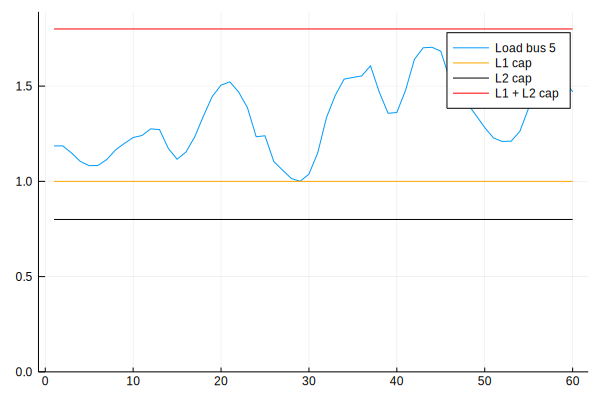

In [14]:
load_5_scale = 0.85
load_5 = extradata["load"]["5"]["pd"]*load_5_scale
ntime = length(load_5)
pd = reshape(load_5,(ntime,1))
t = collect(1:ntime)
cap_L1 = data["branch"]["1"]["rate_a"]
cap_L2 = data["branch"]["2"]["rate_a"]
cap_L1L2 = cap_L1 + cap_L2

pd_max = maximum(pd)
max_val = maximum([pd_max, cap_L1L2])

line_cap_plot = plot(t, pd, ylim = (0,max_val*1.05), label = "Load bus 5")
plot!([first(t), last(t)], [cap_L1, cap_L1], label = "L1 cap", color = "orange")
plot!([first(t), last(t)], [cap_L2, cap_L2], label = "L2 cap", color = "black")
plot!([first(t), last(t)], [cap_L1L2, cap_L1L2], label = "L1 + L2 cap", color = "red")
display(line_cap_plot)

We scale the bus 5 load such that lines 1 and 2 can supply the load by themself:

In [15]:
extradata["load"]["5"]["pd"] *= load_5_scale;

We also have to scale generation in bus 1 to get enough generation through line 1:

In [16]:
gen_1_scale = (1.8/1.4)
extradata["gen"]["1"]["pmax"] *= gen_1_scale;
data["gen"]["1"]["pmax"] *= gen_1_scale;

In [17]:
data["branchdc_ne"]["3"]["cost"] *= 50

2.9166666666666665

Create data dictionary where time series data is included at the right place

In [18]:
mn_data = _PMACDC.multinetwork_data(data, extradata, Set{String}(["source_type", "contingency", "contingency_prob", "name", "source_version", "per_unit"]))

Dict{String,Any} with 8 entries:
  "name"             => "60 replicates of case6"
  "contingency"      => Dict{String,Any}("0"=>Dict{Any,Any}("32"=>32,"29"=>29,"…
  "source_version"   => "2"
  "contingency_prob" => Dict{String,Any}("0"=>1.0)
  "multinetwork"     => true
  "nw"               => Dict{String,Any}("32"=>Dict{String,Any}("ne_branch"=>Di…
  "per_unit"         => true
  "source_type"      => "matpower"

 Add PowerModels(ACDC) settings

In [19]:
s = Dict("output" => Dict("branch_flows" => true), "conv_losses_mp" => false, "process_data_internally" => false)

Dict{String,Any} with 3 entries:
  "conv_losses_mp"          => false
  "output"                  => Dict{String,Bool}("branch_flows"=>1)
  "process_data_internally" => false

Solve the model for base case:

In [20]:
result_base = _FP.reliability_tnep(mn_data, _PM.DCPPowerModel, cbc, multinetwork=true; setting = s);

 | PowerModels]: For converter 4 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 2 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 3 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 1 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: no reference DC bus found, setting reference bus based on AC bus type
[warn | PowerModels]: For converter 4 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 2 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 3 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerMode

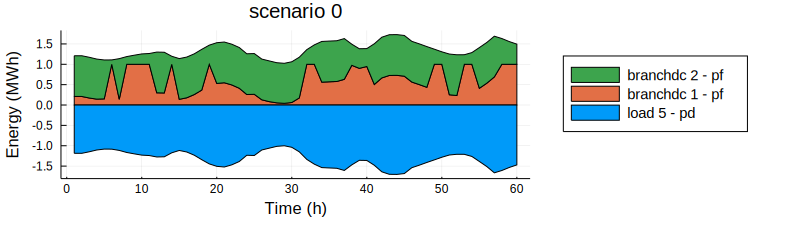

In [21]:
enbal_plot = _FP.plot_energy_balance_scenarios(mn_data, result_base, data["contingency"], 5);

In [22]:
savefig(enbal_plot, "energy_balance_base.png")

Reset and double load from original value:

In [23]:
extradata["load"]["5"]["pd"] *= (2/load_5_scale);
mn_data = _PMACDC.multinetwork_data(data, extradata, Set{String}(["source_type", "contingency", "contingency_prob", "name", "source_version", "per_unit"]))

Dict{String,Any} with 8 entries:
  "name"             => "60 replicates of case6"
  "contingency"      => Dict{String,Any}("0"=>Dict{Any,Any}("32"=>32,"29"=>29,"…
  "source_version"   => "2"
  "contingency_prob" => Dict{String,Any}("0"=>1.0)
  "multinetwork"     => true
  "nw"               => Dict{String,Any}("32"=>Dict{String,Any}("ne_branch"=>Di…
  "per_unit"         => true
  "source_type"      => "matpower"

Solve

In [24]:
result_base = _FP.reliability_tnep(mn_data, _PM.DCPPowerModel, cbc, multinetwork=true; setting = s);

 | PowerModels]: no reference DC bus found, setting reference bus based on AC bus type
[warn | PowerModels]: For converter 4 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 2 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 3 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 1 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: no reference DC bus found, setting reference bus based on AC bus type
[warn | PowerModels]: For converter 4 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 2 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 3 is chosen P is 

Plot

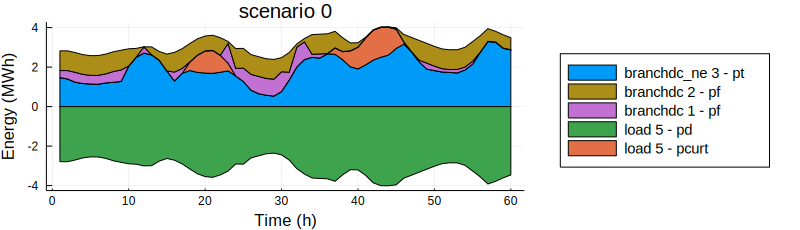

In [25]:
enbal_plot = _FP.plot_energy_balance_scenarios(mn_data, result_base, data["contingency"], 5);

In [26]:
savefig(enbal_plot, "energy_balance_base_2x_load.png")

Set load to 10 times original value:

In [27]:
extradata["load"]["5"]["pd"] *= (10/2);
mn_data = _PMACDC.multinetwork_data(data, extradata, Set{String}(["source_type", "contingency", "contingency_prob", "name", "source_version", "per_unit"]))

Dict{String,Any} with 8 entries:
  "name"             => "60 replicates of case6"
  "contingency"      => Dict{String,Any}("0"=>Dict{Any,Any}("32"=>32,"29"=>29,"…
  "source_version"   => "2"
  "contingency_prob" => Dict{String,Any}("0"=>1.0)
  "multinetwork"     => true
  "nw"               => Dict{String,Any}("32"=>Dict{String,Any}("ne_branch"=>Di…
  "per_unit"         => true
  "source_type"      => "matpower"

Solve

In [28]:
result_base = _FP.reliability_tnep(mn_data, _PM.DCPPowerModel, cbc, multinetwork=true; setting = s);

s fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 2 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 3 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 1 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: no reference DC bus found, setting reference bus based on AC bus type
[warn | PowerModels]: For converter 4 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 2 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 3 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 1 is chosen P is fixed on A

Plot

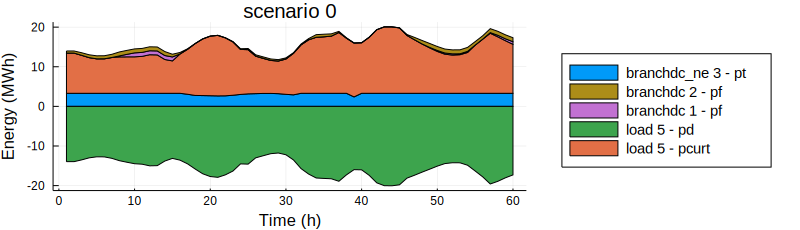

In [29]:
enbal_plot = _FP.plot_energy_balance_scenarios(mn_data, result_base, data["contingency"], 5);

**Issue 1: **{style="color:red"} There are no limits on curtailed power (variable: pcurt), such that interrupted power is never used.

# Load shedding due to contingencies

After implementing contingency constraints and the objective function term for costs of energy not supplied due to contingencies, one could replicate the load shedding tests above where two branches feeding load bus 5 are sufficient to supply the load demand but a single branch is not. In the "base case" (intact grid) both branches feeding the load bus should be in an up state, and one of the branches should be included in the contingency list. In this case, load shedding should be represented in the solution by non-zero values for the slack variable $\Delta P_{u,c,t,y}$  in the contingency case c=1 and not by any of the other slack variables, and there should be no load shedding in the non-contingency case c=0.

In [30]:
scenario = Dict{String, Any}("hours" => number_of_hours, "contingency" => Dict{String, Any}())
# Base scenario
scenario["contingency"]["0"] = Dict{String, Any}()
scenario["contingency"]["0"]["year"] = 2019
scenario["contingency"]["0"]["start"] = 1546300800000   # 01.01.2019:00:00 in epoch time
scenario["contingency"]["0"]["probability"] = 0.98
scenario["contingency"]["0"]["faults"] = Dict()
# Contingency 1
scenario["contingency"]["1"] = Dict{String, Any}()
scenario["contingency"]["1"]["year"] = 2019
scenario["contingency"]["1"]["start"] = 1546300800000   # 01.01.2019:00:00 in epoch time
scenario["contingency"]["1"]["probability"] = 0.01
scenario["contingency"]["1"]["faults"] = Dict("branchdc" => [1])  
# Contingency 2
scenario["contingency"]["2"] = Dict{String, Any}()
scenario["contingency"]["2"]["year"] = 2019
scenario["contingency"]["2"]["start"] = 1546300800000 # 01.01.2019:00:00 in epoch time 
scenario["contingency"]["2"]["probability"] = 0.01
scenario["contingency"]["2"]["faults"] = Dict("branchdc" => [2])
scenario["utypes"] = ["branchdc"] # type of lines considered in contingencies
scenario["planning_horizon"] = 1 # in years, to scale generation cost  

1

In [31]:
data = _PM.parse_file(file); # Create PowerModels data dictionary (AC networks and storage)
data, contingency_profile, loadprofile, genprofile = _FP.create_contingency_data_italy(data, scenario) # create load and generation profiles
_PMACDC.process_additional_data!(data) # Add DC grid data to the data dictionary
_FP.add_storage_data!(data) # Add addtional storage data model
_FP.add_flexible_demand_data!(data) # Add flexible data model
_FP.scale_cost_data!(data, scenario) # Scale cost data
dim = number_of_hours * length(data["contingency"])
extradata = _FP.create_contingency_data(dim, data, contingency_profile, loadprofile, genprofile) # create a dictionary to pass time series


[info | PowerModels]: extending matpower format with data: storage_extra 1x4
[info | PowerModels]: extending matpower format with data: convdc 4x35
[info | PowerModels]: extending matpower format with data: busdc 4x9
[info | PowerModels]: extending matpower format with data: convdc_ne 6x37
[info | PowerModels]: extending matpower format with data: ne_storage 1x25
[info | PowerModels]: extending matpower format with data: busdc_ne 4x9
[info | PowerModels]: extending matpower format with data: load_extra 5x19
[info | PowerModels]: extending matpower format with data: branchdc_ne 3x12
[info | PowerModels]: extending matpower format with data: ne_branch 2x15
[info | PowerModels]: extending matpower format with data: branchdc 2x10
[info | PowerModels]: extending matpower format with constant data: time_elapsed
[info | PowerModels]: extending matpower format by appending matrix "storage_extra" in to "storage"
[warn | PowerModels]: the voltage setpoint on generator 2 does not match the value 

Dict{String,Any} with 4 entries:
  "gen"      => Dict{String,Any}("4"=>Dict{String,Any}("pmax"=>[1.2 1.2 … 1.2 1…
  "dim"      => 180
  "load"     => Dict{String,Any}("4"=>Dict{String,Any}("pd"=>[0.844133 0.83063 …
  "branchdc" => Dict{String,Any}("1"=>Dict{String,Any}("status"=>[1.0 1.0 … 1.0…

Scale the load and generation as previously:

In [32]:
extradata["load"]["5"]["pd"] *= load_5_scale;
extradata["gen"]["1"]["pmax"] *= gen_1_scale;
data["gen"]["1"]["pmax"] *= gen_1_scale;
data["branchdc_ne"]["3"]["cost"] *= 100000 # Making building dc line candidate nr. 3 too expensive 

5833.333333333333

Create multi-network data:

In [33]:
mn_data = _PMACDC.multinetwork_data(data, extradata, Set{String}(["source_type", "contingency", "contingency_prob", "name", "source_version", "per_unit"]))

Dict{String,Any} with 8 entries:
  "name"             => "180 replicates of case6"
  "contingency"      => Dict{String,Any}("1"=>Dict{Any,Any}("32"=>92,"29"=>89,"…
  "source_version"   => "2"
  "contingency_prob" => Dict{String,Any}("1"=>0.01,"0"=>0.98,"2"=>0.01)
  "multinetwork"     => true
  "nw"               => Dict{String,Any}("1"=>Dict{String,Any}("ne_branch"=>Dic…
  "per_unit"         => true
  "source_type"      => "matpower"

Solve:

In [34]:
result_2con = _FP.reliability_tnep(mn_data, _PM.DCPPowerModel, cbc, multinetwork=true; setting = s);

 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 2 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 3 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 1 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: no reference DC bus found, setting reference bus based on AC bus type
[warn | PowerModels]: For converter 4 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 2 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 3 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 1 is chosen P

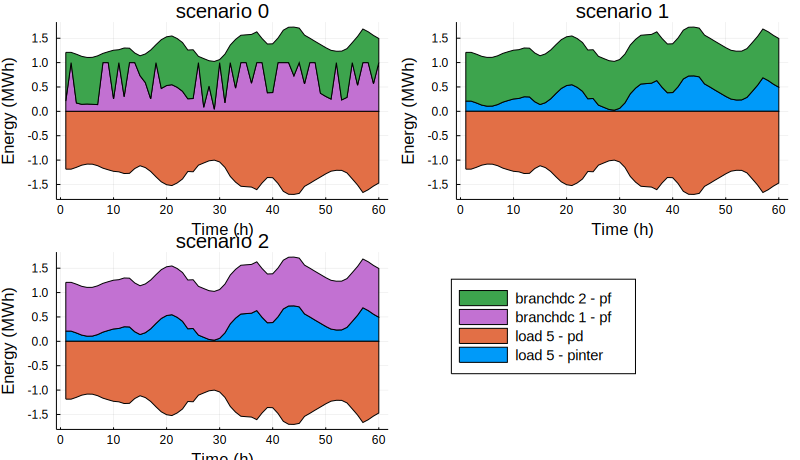

In [35]:
enbal_plot = _FP.plot_energy_balance_scenarios(mn_data, result_2con, data["contingency"], 5);

In [36]:
savefig(enbal_plot, "energy_balance_2scen_high_inv_cost.png")

We get the following investments:

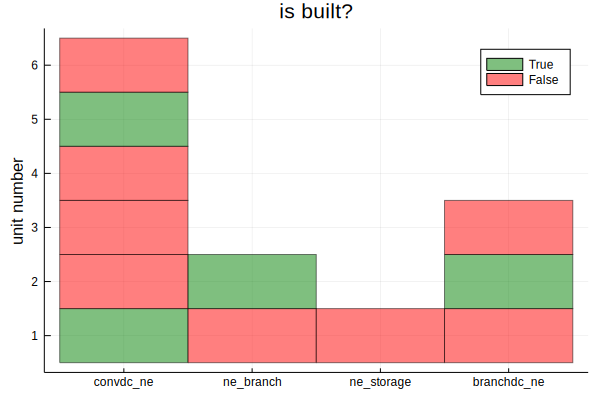

In [37]:
_FP.plot_inv_matrix(result_2con, data["contingency"], "0")

In [38]:
extradata["load"]["5"]["pd"] *= (2/load_5_scale);
data["branchdc_ne"]["3"]["cost"] *= (50/100000) 
mn_data = _PMACDC.multinetwork_data(data, extradata, Set{String}(["source_type", "contingency", "contingency_prob", "name", "source_version", "per_unit"]))
result_2con = _FP.reliability_tnep(mn_data, _PM.DCPPowerModel, cbc, multinetwork=true; setting = s);

 AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 1 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: no reference DC bus found, setting reference bus based on AC bus type
[warn | PowerModels]: For converter 4 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 2 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 3 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 1 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: no reference DC bus found, setting reference bus based on AC bus type
[warn | PowerModels]: For converter 4 is chosen P is fixed on AC and DC side. This can lead to infeasibility 

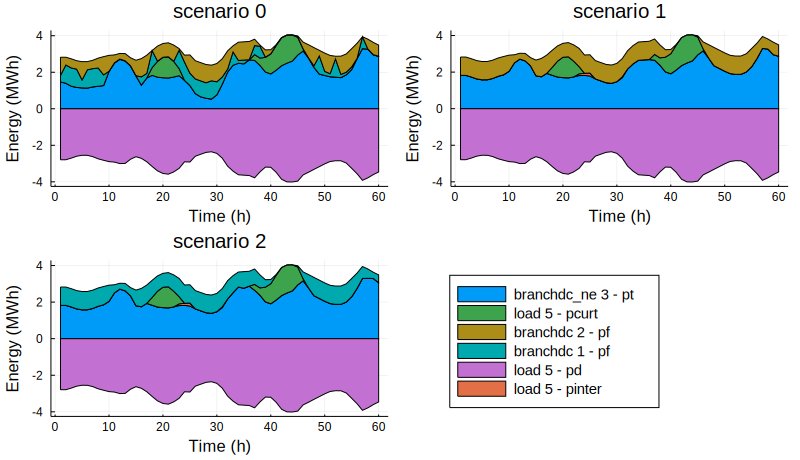

In [39]:
enbal_plot = _FP.plot_energy_balance_scenarios(mn_data, result_2con, data["contingency"], 5);

In [40]:
savefig(enbal_plot, "energy_balance_2scen_2xload.png")

Reset investment costs for new dc line nr. 3 to same as base case (10 times costs from input file - not profitable without contingencies): 

In [41]:
extradata["load"]["5"]["pd"] *= (load_5_scale/2);
mn_data = _PMACDC.multinetwork_data(data, extradata, Set{String}(["source_type", "contingency", "contingency_prob", "name", "source_version", "per_unit"]))
result_2con = _FP.reliability_tnep(mn_data, _PM.DCPPowerModel, cbc, multinetwork=true; setting = s);

nce bus based on AC bus type
[warn | PowerModels]: For converter 4 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 2 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 3 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 1 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: no reference DC bus found, setting reference bus based on AC bus type
[warn | PowerModels]: For converter 4 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 2 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 3 is chosen P is fixed on AC and DC side. This can lead to infeasibility in

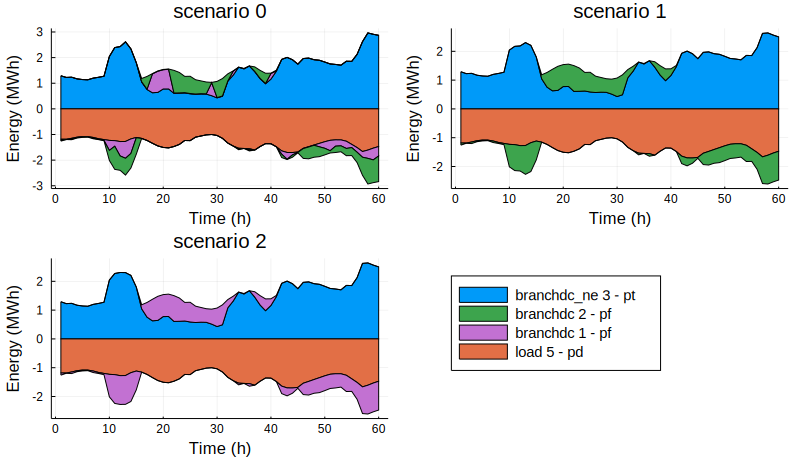

In [42]:
enbal_plot = _FP.plot_energy_balance_scenarios(mn_data, result_2con, data["contingency"], 5);

In [43]:
savefig(enbal_plot, "energy_balance_2scen.png")

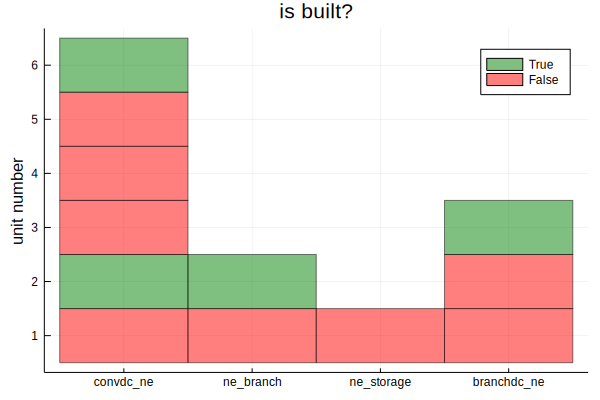

In [44]:
_FP.plot_inv_matrix(result_2con, data["contingency"], "0")

# Sensitivity tests

Increasing the failure rate or mean time to repair:
 - Increasing the value of the failure rate of a branch or the mean time to repair for a branch should give changes in the objective value that can be verified analytically.


Change scenario probability:

In [45]:
scenario["contingency"]["0"]["probability"] = 0.8 # old: 0.98 
scenario["contingency"]["1"]["probability"] = 0.2 # old: 0.01 
scenario["contingency"]["2"]["probability"] = 0.2 # old: 0.01 

0.2

Set new data:

In [46]:
data = _PM.parse_file(file); # Create PowerModels data dictionary (AC networks and storage)
data, contingency_profile, loadprofile, genprofile = _FP.create_contingency_data_italy(data, scenario) # create load and generation profiles
_PMACDC.process_additional_data!(data) # Add DC grid data to the data dictionary
_FP.add_storage_data!(data) # Add addtional storage data model
_FP.add_flexible_demand_data!(data) # Add flexible data model
_FP.scale_cost_data!(data, scenario) # Scale cost data
dim = number_of_hours * length(data["contingency"])
extradata = _FP.create_contingency_data(dim, data, contingency_profile, loadprofile, genprofile) # create a dictionary to pass time series
extradata["load"]["5"]["pd"] *= load_5_scale;
extradata["gen"]["1"]["pmax"] *= gen_1_scale;
data["gen"]["1"]["pmax"] *= gen_1_scale;
data["branchdc_ne"]["3"]["cost"] *= 50;
mn_data = _PMACDC.multinetwork_data(data, extradata, Set{String}(["source_type", "contingency", "contingency_prob", "name", "source_version", "per_unit"]))

[info | PowerModels]: extending matpower format with data: storage_extra 1x4
[info | PowerModels]: extending matpower format with data: convdc 4x35
[info | PowerModels]: extending matpower format with data: busdc 4x9
[info | PowerModels]: extending matpower format with data: convdc_ne 6x37
[info | PowerModels]: extending matpower format with data: ne_storage 1x25
[info | PowerModels]: extending matpower format with data: busdc_ne 4x9
[info | PowerModels]: extending matpower format with data: load_extra 5x19
[info | PowerModels]: extending matpower format with data: branchdc_ne 3x12
[info | PowerModels]: extending matpower format with data: ne_branch 2x15
[info | PowerModels]: extending matpower format with data: branchdc 2x10
[info | PowerModels]: extending matpower format with constant data: time_elapsed
[info | PowerModels]: extending matpower format by appending matrix "storage_extra" in to "storage"
[warn | PowerModels]: the voltage setpoint on generator 2 does not match the value 

Dict{String,Any} with 8 entries:
  "name"             => "180 replicates of case6"
  "contingency"      => Dict{String,Any}("1"=>Dict{Any,Any}("32"=>92,"29"=>89,"…
  "source_version"   => "2"
  "contingency_prob" => Dict{String,Any}("1"=>0.2,"0"=>0.8,"2"=>0.2)
  "multinetwork"     => true
  "nw"               => Dict{String,Any}("1"=>Dict{String,Any}("ne_branch"=>Dic…
  "per_unit"         => true
  "source_type"      => "matpower"

Solve and plot:

In [47]:
result_2con_high_prob = _FP.reliability_tnep(mn_data, _PM.DCPPowerModel, cbc, multinetwork=true; setting = s);

els]: no reference DC bus found, setting reference bus based on AC bus type
[warn | PowerModels]: For converter 4 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 2 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 3 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 1 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: no reference DC bus found, setting reference bus based on AC bus type
[warn | PowerModels]: For converter 4 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 2 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 3 is chosen P is fixed on AC

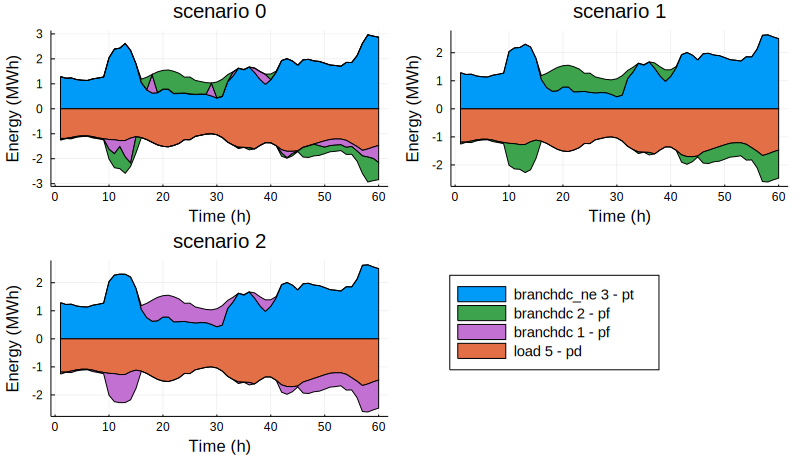

In [48]:
enbal_plot = _FP.plot_energy_balance_scenarios(mn_data, result_2con_high_prob, data["contingency"], 5);

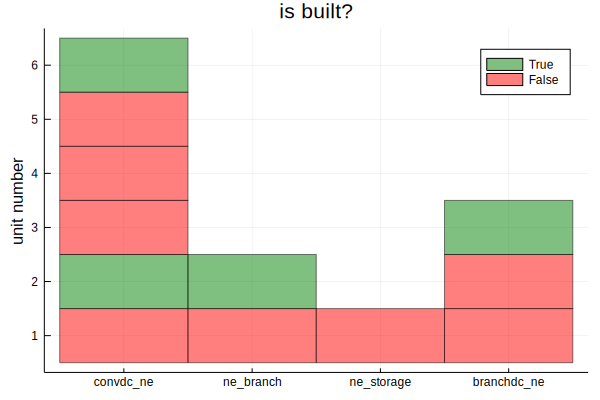

In [49]:
_FP.plot_inv_matrix(result_2con, data["contingency"], "0")

In [50]:
using Printf 
@printf("Objective value low prob: %.2f \n", result_2con["objective"])
@printf("Objective value high prob: %.2f \n", result_2con_high_prob["objective"])
@printf("Relative increase: %.2f percent \n", (result_2con_high_prob["objective"]-result_2con["objective"])*100/result_2con["objective"])

Objective value low prob: 57777.59 
Objective value high prob: 69433.46 
Relative increase: 20.17 percent 


Branches subject to outage:
-	One can specify which branches are subject to outage or in other words included in the contingency list. E.g. one could include both branches feeding the load bus under study rather than just one, or all 4 branches feeding load buses 4 and 5, or all branches in the network.
- We have shown this for 0 and two branches above

Combining reliability modelling with transmission expansion:
-	It should be possible to combine contingency constraints with the specification of candidate branches to solve a transmission expansion problem considering contingencies. If only existing branches are subject to outage and if no branches connected to load buses 4 and 5 are candidates, this should not influence the results significantly(?) 

Reliability-driven transmission expansion:
- If the value of lost load at load bus 4 or 5 is set sufficiently high, this should incentivize the investment in a transmission line in parallel with the lines already supplying these load buses. This should also be possible to achieve by increasing the failure rate and/or the mean time to repair for the branches.

Reliability-driven transmission expansion:
-	If the value of lost load at load bus 4 or 5 is set sufficiently high, this should incentivize the investment in a transmission line in parallel with the lines already supplying these load buses. This should also be possible to achieve by increasing the failure rate and/or the mean time to repair for the branches.

Candidate branches subject to outage:
-	It should be possible to specify that a candidate branch is subject to outage and included in the contingency set. If the failure rate is sufficiently high, this should disincentivize the investment in this line, requiring the investment cost to be lower for the line to be build according to the optimization model.

Combining reliability modelling with multi-period OPF:
-	It should be possible to straightforwardly combine contingency constraints with going from a single-period OPF to a multi-period OPF formulation, e.g. a 24-period problem for a single day. If the load demand at the buses of interest (4 and 5) varies significantly during the day, it should be possible to see a corresponding variation in the solution for the load shedding (slack) variable and in the contributions to the cost of energy not supplied in the objective function.

Combining reliability modelling with flexibility modelling:
-	It should be possible to straightforwardly combine contingency constraints with flexibility elements e.g. at the load buses 4 or 5. The interactions may be easiest to investigate by first considering a pre-installed flexibility element (i.e. not a candidate). A storage element at the bus at which we are provoking load shedding should reduce the costs of energy not supplied, but it has to be considered more closely how these interactions will play out. Similarly, a demand flexibility at these load buses should give solutions with (voluntary) curtailment of load (and possibly shifting of load) rather than (involuntary) shedding of load. (This requires that the constraints and objective function terms for the flexibility elements are replicated in the model formulation for all contingencies.) There are probably also more subtle interactions that are not anticipated at the test planning stage…

In [51]:

scenario = Dict{String, Any}("hours" => number_of_hours, "contingency" => Dict{String, Any}())
# Base scenario
scenario["contingency"]["0"] = Dict{String, Any}()
scenario["contingency"]["0"]["year"] = 2019
scenario["contingency"]["0"]["start"] = 1546300800000   # 01.01.2019:00:00 in epoch time
scenario["contingency"]["0"]["probability"] = 0.97
scenario["contingency"]["0"]["faults"] = Dict()
# Contingency 1
scenario["contingency"]["1"] = Dict{String, Any}()
scenario["contingency"]["1"]["year"] = 2019
scenario["contingency"]["1"]["start"] = 1546300800000   # 01.01.2019:00:00 in epoch time
scenario["contingency"]["1"]["probability"] = 0.01
scenario["contingency"]["1"]["faults"] = Dict("branchdc" => [1])  
# Contingency 2
scenario["contingency"]["2"] = Dict{String, Any}()
scenario["contingency"]["2"]["year"] = 2019
scenario["contingency"]["2"]["start"] = 1546300800000 # 01.01.2019:00:00 in epoch time 
scenario["contingency"]["2"]["probability"] = 0.01
scenario["contingency"]["2"]["faults"] = Dict("branchdc" => [2])
# Contingency 3
scenario["contingency"]["3"] = Dict{String, Any}()
scenario["contingency"]["3"]["year"] = 2019
scenario["contingency"]["3"]["start"] = 1546300800000 # 01.01.2019:00:00 in epoch time 
scenario["contingency"]["3"]["probability"] = 0.01
scenario["contingency"]["3"]["faults"] = Dict("branchdc_ne" => [3])
scenario["utypes"] = ["branchdc", "branchdc_ne"] # type of lines considered in contingencies
scenario["planning_horizon"] = 1 # in years, to scale generation cost

1

In [52]:
data = _PM.parse_file(file); # Create PowerModels data dictionary (AC networks and storage)
data, contingency_profile, loadprofile, genprofile = _FP.create_contingency_data_italy(data, scenario) # create load and generation profiles
_PMACDC.process_additional_data!(data) # Add DC grid data to the data dictionary
_FP.add_storage_data!(data) # Add addtional storage data model
_FP.add_flexible_demand_data!(data) # Add flexible data model
_FP.scale_cost_data!(data, scenario) # Scale cost data
dim = number_of_hours * length(data["contingency"])
extradata = _FP.create_contingency_data(dim, data, contingency_profile, loadprofile, genprofile) # create a dictionary to pass time series
mn_data = _PMACDC.multinetwork_data(data, extradata, Set{String}(["source_type", "contingency", "contingency_prob", "name", "source_version", "per_unit"]))

[info | PowerModels]: extending matpower format with data: storage_extra 1x4
[info | PowerModels]: extending matpower format with data: convdc 4x35
[info | PowerModels]: extending matpower format with data: busdc 4x9
[info | PowerModels]: extending matpower format with data: convdc_ne 6x37
[info | PowerModels]: extending matpower format with data: ne_storage 1x25
[info | PowerModels]: extending matpower format with data: busdc_ne 4x9
[info | PowerModels]: extending matpower format with data: load_extra 5x19
[info | PowerModels]: extending matpower format with data: branchdc_ne 3x12
[info | PowerModels]: extending matpower format with data: ne_branch 2x15
[info | PowerModels]: extending matpower format with data: branchdc 2x10
[info | PowerModels]: extending matpower format with constant data: time_elapsed
[info | PowerModels]: extending matpower format by appending matrix "storage_extra" in to "storage"
[warn | PowerModels]: the voltage setpoint on generator 2 does not match the value 

Dict{String,Any} with 8 entries:
  "name"             => "240 replicates of case6"
  "contingency"      => Dict{String,Any}("1"=>Dict{Any,Any}("32"=>92,"29"=>89,"…
  "source_version"   => "2"
  "contingency_prob" => Dict{String,Any}("1"=>0.01,"0"=>0.97,"2"=>0.01,"3"=>0.0…
  "multinetwork"     => true
  "nw"               => Dict{String,Any}("1"=>Dict{String,Any}("ne_branch"=>Dic…
  "per_unit"         => true
  "source_type"      => "matpower"

In [53]:
extradata["load"]["5"]["pd"] *= load_5_scale;
extradata["gen"]["1"]["pmax"] *= gen_1_scale;
data["gen"]["1"]["pmax"] *= gen_1_scale;
data["branchdc_ne"]["3"]["cost"] *= 10 

0.5833333333333334

In [54]:
result_3con = _FP.reliability_tnep(mn_data, _PM.DCPPowerModel, cbc, multinetwork=true; setting = s);

 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 2 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 3 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 1 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: no reference DC bus found, setting reference bus based on AC bus type
[warn | PowerModels]: For converter 4 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 2 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 3 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 1 is chosen P

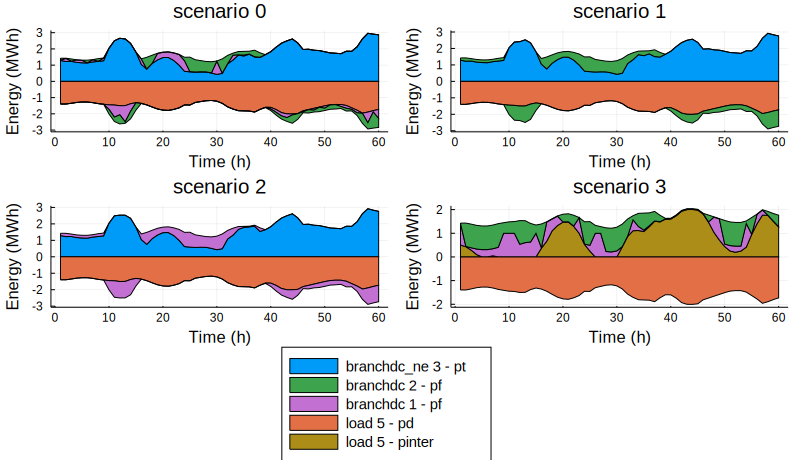

In [55]:
enbal_plot = _FP.plot_energy_balance_scenarios(mn_data, result_3con, data["contingency"], 5);

In [56]:
savefig(enbal_plot, "energy_balance_3scen.png")